<a href="https://colab.research.google.com/github/qazwsx351789/DEEP-LEARNING-FOR-BIG-VISUAL-DATA/blob/main/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 1: Image Classification on Imbalanced Dataset

## Q1: Prepare CIFAR-50 Dataset

Download dataset to your Google Drive from https://drive.google.com/drive/folders/1WGUKBP5Eta9DAltK1WtvRbX43iwP08DU?usp=sharing

Unzip the files.

In [ ]:
# todo: you can change to your download location
from google.colab import drive
drive.mount('/content/gdrive')
!mkdir ./data
!mkdir ./data/cifar50
!unzip /content/gdrive/MyDrive/Data/cifar50.zip -d ./data/cifar50

MessageError: ignored

In [ ]:
# todo: you can change to your download location

!mkdir ./data/cifar50_imbalance_0.02
!unzip /content/gdrive/MyDrive/Data/cifar50_imbalance_0.02.zip -d ./data/cifar50_imbalance_0.02

mkdir: cannot create directory ‘./data/cifar50_imbalance_0.02’: File exists
Archive:  /content/gdrive/MyDrive/Data/cifar50_imbalance_0.02.zip
replace ./data/cifar50_imbalance_0.02/cifar50_imbalance_0.02_test.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Load and print label files to know the format of the provided labels.
- `cifar50_train.json`
- `cifar50_imbalance_0.02_train.json`

In [ ]:
from torchvision import transforms, datasets
from torch.utils.data import TensorDataset, DataLoader
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
           'ship', 'truck')
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar10_trainset = datasets.CIFAR10(root='./data/', train=True, download=True, transform=transform)
cifar10_testset = datasets.CIFAR10(root='./data/', train=False, download=True, transform=transform)

cifar_loader = DataLoader(cifar10_trainset, batch_size=len(cifar10_trainset), shuffle=False)
cifar_test_loader = DataLoader(cifar10_testset, batch_size=len(cifar10_testset), shuffle=False)

100%|██████████| 170498071/170498071 [00:13<00:00, 13026359.90it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data/
Files already downloaded and verified


In [ ]:
import torchvision
import random
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image

class Cifar10Imbanlance(Dataset):
    def __init__(self, imbanlance_rate=0.5, num_cls=10, file_path="data/",
                 train=True, transform=None, label_align=True, ):
        self.transform = transform
        self.label_align = label_align
        assert 0.0 < imbanlance_rate < 1, "imbanlance_rate must 0.0 < imbanlance_rate < 1"
        self.imbanlance_rate = imbanlance_rate

        self.num_cls = num_cls
        self.data = self.produce_imbanlance_data(file_path=file_path, train=train,imbanlance_rate=self.imbanlance_rate)
        self.x = self.data['x']
        self.targets = self.data['y'].tolist()
        self.y = self.data['y'].tolist()

    def __len__(self):
        return len(self.x)

    def __getitem__(self, item):
        x, y = self.x[item], self.y[item]
        x = Image.fromarray(x)
        if self.transform is not None:
            x = self.transform(x)
        return x, y

    def get_per_class_num(self):
        return self.class_list

    def produce_imbanlance_data(self, imbanlance_rate, file_path="/data", train=True):

        train_data = torchvision.datasets.CIFAR10(
            root=file_path,
            train=train,
            download=True,
        )
        x_train = train_data.data
        y_train = train_data.targets
        y_train = np.array(y_train)

        rehearsal_data = None
        rehearsal_label = None

        data_percent = []
        data_num = int(x_train.shape[0] / self.num_cls)

        for cls_idx in range(self.num_cls):
            if train:
                num = data_num * (imbanlance_rate ** (cls_idx / (self.num_cls - 1)))
                data_percent.append(int(num))
            else:
                num = data_num
                data_percent.append(int(num))
        if train:
            print("imbanlance_ration is {}".format(data_percent[0] / data_percent[-1]))
            print("per class num: {}".format(data_percent))

        self.class_list = data_percent



        for i in range(1, self.num_cls + 1):
            a1 = y_train >= i - 1
            a2 = y_train < i
            index = a1 & a2
            task_train_x = x_train[index]
            label = y_train[index]
            data_num = task_train_x.shape[0]
            index = np.random.choice(data_num, data_percent[i - 1])
            tem_data = task_train_x[index]
            tem_label = label[index]
            if rehearsal_data is None:
                rehearsal_data = tem_data
                rehearsal_label = tem_label
            else:
                rehearsal_data = np.concatenate([rehearsal_data, tem_data], axis=0)
                rehearsal_label = np.concatenate([rehearsal_label, tem_label], axis=0)

        task_split = {
            "x": rehearsal_data,
            "y": rehearsal_label,
        }
        return task_split

In [ ]:
cifar10_trainset_Imbalence = Cifar10Imbanlance()

Files already downloaded and verified
imbanlance_ration is 2.0
per class num: [5000, 4629, 4286, 3968, 3674, 3401, 3149, 2916, 2700, 2500]


Show some images with labels (class names) from dataset.

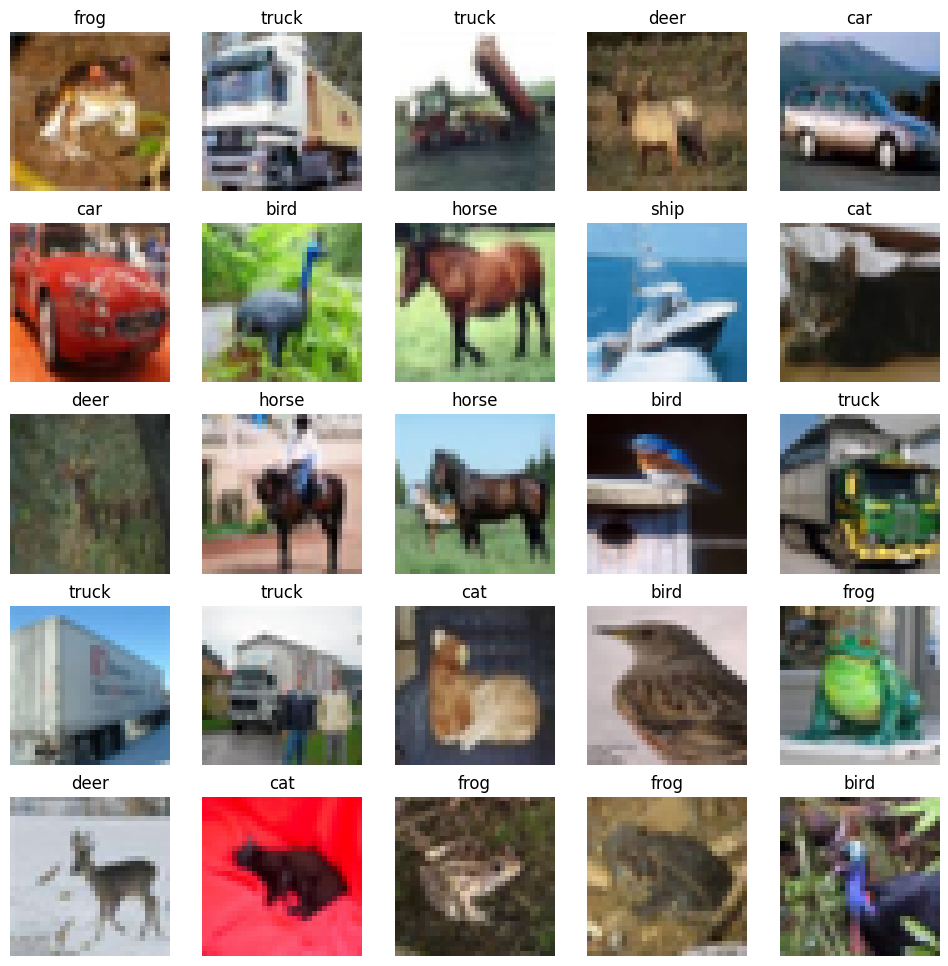

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

def cifar_imshow(img):
  img = img /2 + 0.5
  npimg = img.numpy()
  return np.transpose(npimg, (1, 2, 0))

fig, axs = plt.subplots(5, 5, figsize = (12, 12))

for i, ax in enumerate(axs.flat):

  ax.imshow(cifar_imshow(cifar10_trainset[i][0]))
  ax.axis('off')
  ax.set_title('{}'.format(classes[cifar10_trainset[i][1]]))

## Q2: Train CNNs.

#### Use the CNN in HW2 to train the model on the balanced CIFAR50 dataset.

Train the CNN on the balanced CIFAR50 training set. Evaluate and report the classification accuracies on the testing set.

Note: You can use any network configurations you implemented in HW2.

In [ ]:

# todo
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN1(nn.Module):
  def __init__(self):
    super(CNN1,self).__init__()
    # TODO: define your CNN
    self.conv1 = nn.Conv2d(3,32,kernel_size=3, dilation=1,stride=1,padding ="same")
    self.conv2 = nn.Conv2d(32,64,kernel_size=3, dilation=1,stride=1,padding ="same")
    self.conv3 = nn.Conv2d(64,128,kernel_size=3, dilation=1,stride=1,padding ="same")



    self.fc1 = nn.Linear(512, 128)
    self.dropout = nn.Dropout(p=0.3)
    self.fc2 = nn.Linear(128, 20)
    self.fc3 = nn.Linear(20, 10)



  def forward(self, x):
    # TODO: define your forward function

    x = F.max_pool2d(F.relu(self.conv1(x)),2)
    x = self.dropout(x)
    x = F.max_pool2d(F.relu(self.conv2(x)),2)
    x = self.dropout(x)
    x = F.relu(self.conv3(x))

    x = x.view(-1,self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = (self.fc3(x))

    return x

  def num_flat_features(self, x):
    size = x.size()[1:]
    num_features = 1
    for i in size:
      num_features *= i
    return num_features

cnn1 = CNN1().to(device)  # operate on GPU

In [ ]:
# TODO: write your training code
def train(dataloader,model,loss_fn,optimizer):
  size = len(dataloader.dataset)
  for batch,(X,y) in enumerate(dataloader):

    pred = model(X)
    loss = loss_fn(pred,y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

# TODO: write your testing code
def test(dataloader,model,loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss,correct = 0 ,0

  with torch.no_grad():
    for x,y in dataloader:
      pred = model(x)
      test_loss += loss_fn(pred,y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%,Avg loss: {test_loss:>8f} \n")

In [ ]:
import torch.optim as optim

# TODO: you can change loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn1.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

In [ ]:
n_epoch=5
for epoch in range(n_epoch):
  train(cifar_loader,cnn1,criterion,optimizer)

RuntimeError: ignored

#### Use the same CNN above to train the model on the imbalanced CIFAR50 dataset.

Train the CNN on the imbalanced CIFAR50 training set. Evaluate and report the classification accuracies on the testing set.


In [ ]:
# todo


## Implement Tricks for LTR

Before starting this question, please read the paper on Canvas: Bag of tricks for long-tailed visual recognition with deep convolutional neural networks.

According to this paper, select at least **three** tricks to implement on the imbalanced CIFAR50 training.

Trick 1

In [ ]:
# todo


Trick 2

In [ ]:
# todo


Trick 3

In [ ]:
# todo

Paste performance above to this table

|          | Baseline | Trick1 |Trick2| Trick|
|----------|:-----:|:-----------:|:-----------:|:-----------:|
| Test Accuracy (%) |  | | | |

# Problem 2: Transfer Learning and Domain Adaptation

The goal of domain adaptation is to transfer the knowledge of a model to a different but related data distribution. The model is trained on a source dataset and applied to a target dataset (usually unlabeled). For Problem 3, the model will be trained on regular MNIST images, but we want to get good performance on MNIST with random color (without any labels).


**Problem Statement** Given a labelled source domain (MNIST) and an unlabelled target domain (MNIST-M). We would like to train a classifier or a predictor which would give accurate predictions on the target domain.

**Assumptions** Probability distribution of source domain is not equal to the probability distribution of target domain. The conditional probability distribution of the labels given an instance from the source domain is equal to the conditional probability distribution of the labels given an instance from the target domain. Source dataset is labelled. Target dataset is unlabelled.

**Approach** Here, we adopt the DABP method mentioned in the paper “Unsupervised Domain Adaptation by Backpropagation”.

* Feature Extractor (green): This is a neural network that will learn to perform the transformation on the source and target distribution.
* Label Classifier (blue): This is a neural network that will learn to perform the classification on the transformed source distribution. Since, the source domain is labelled.
* Domain Classifier (red): This is a neural network that will predict whether the output of the Feature Extractor is from the source distribution or the target distribution.



By using the above three components, the Feature Extractor will learn to produce discriminative and domain-invariant features.

In [ ]:
# download the codes from Git
!git clone https://github.com/Haotian-Zhang/Pytorch_DABP.git

Cloning into 'Pytorch_DABP'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 34 (delta 2), reused 1 (delta 1), pack-reused 30
Unpacking objects: 100% (34/34), 17.19 KiB | 1.56 MiB/s, done.


Train the DABP model by running `main.py` and answer the following questions.


* Q1: Perform **3** experiments on training and report your source and target accuracy in the tables below. (Your result is the average of the Target Accs. based on 3 experiments)

**Source Only**

|                | Test1 | Test2 | Test3 |
|----------------|:-----:|:-----:|:-----:|
| Source Acc (%) |  99.06%  |   98.89%    |   99.09%    |
| Target Acc (%) |  65.73%  |   64.01%    |   66.55%   |

|          | Paper | Your Result |
|----------|:-----:|:-----------:|
| DABP (%) | 52.25 |          |

**DANN**

|                | Test1 | Test2 | Test3 |
|----------------|:-----:|:-----:|:-----:|
| Source Acc (%) |  96.70%  |   98.63%    |    97.09%    |
| Target Acc (%) | 68.49%  |   71.47%    |   71.06%    |

|          | Paper | Your Result |
|----------|:-----:|:-----------:|
| DABP (%) | 76.66 |          |



In [ ]:
!python Pytorch_DABP/main.py

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Running GPU : 0
Source-only training
Epoch : 0
/content/Pytorch_DABP/model.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)
[1568/60000 (3%)]	Class Loss: 2.300855
[3168/60000 (6%)]	Class Loss: 2.299610
[4768/60000 (9%)]	Class Loss: 2.293307
[6368/60000 (12%)]	Class Loss: 2.287923
[7968/60000 (14%)]	Class Loss: 2.226723
[9568/60000 (17%)]	Class Loss: 2.119506
[11168/60000 (20%)]	Class Loss: 1.966030
[12768/60000 (23%)]	Cla

* Q2: Write your own codes to visualize the feature space by using the TSNE(perplexity=30, n_components=2, init=’pca’, n_iter=3000). Plot the feature distributions for both (1) original MNIST and MNIST-M inputs and (2) after DABP using source only (3) after DABP using dann.(**You will find useful functions inside the `utils`function.** )

(1) Original MNIST and MNIST-M inputs

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Extract features to draw T-SNE plot...
Draw plot ...
saved_plot/input_mnist_n_mnistM.png is saved


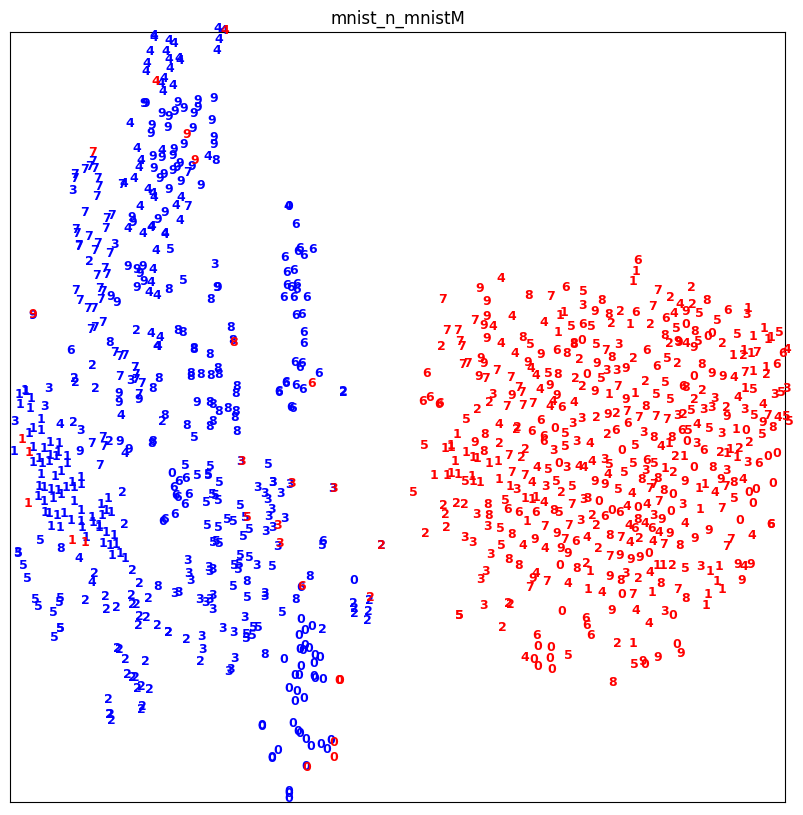

In [ ]:
# todo
import sys
sys.path.append('/content/Pytorch_DABP')
import mnist
import mnistm
import utils
from utils import visualize_input
source_test_loader = mnist.mnist_test_loader
target_test_loader = mnistm.mnistm_test_loader

visualize_input()

(2) After DABP using source only

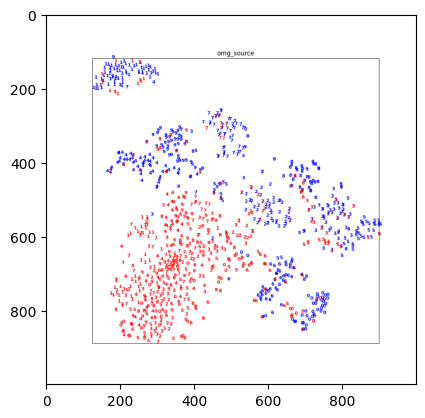

In [ ]:
# todo
from PIL import Image
import matplotlib.pyplot as plt

# 讀取PNG圖片
image = Image.open("./saved_plot/source_omg_source.png")

# 顯示PNG圖片
plt.imshow(image)
plt.show()

 (3) After DABP using dann

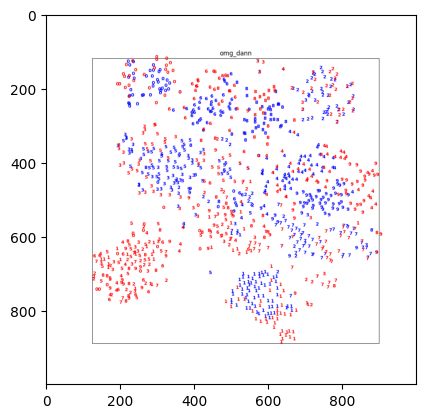

In [ ]:
# todo
from PIL import Image
import matplotlib.pyplot as plt

# 讀取PNG圖片
image = Image.open("./saved_plot/dann_omg_dann.png")

# 顯示PNG圖片
plt.imshow(image)
plt.show()

## Discussions

(1) From the results in Q2, are the both domains closer/farther after performing the transformation? If the answer is closer, it verifies that DABP can learn discriminative and domain invariant features. If not, explain your reasons.



A:Yes,the both domains closer after performing the transformation.

(2) List one of the main problems for the DABP method and explain why?

A:The main problems for the DABP is that the difference between the source and target domains can't be too large. If the difference is large , the performance of the network may be poor.

# Problem 3: GAN
In this problem, we will train a generative adversarial network (GAN) to generate new celebrities after showing it pictures of many real celebrities.

In [ ]:
%matplotlib inline

In [ ]:
from __future__ import print_function

import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
# manualSeed = random.randint(1, 10000)  # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


### (a) Prepare CelebA Dataset

we will use the [Celeb-A Faces
dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) which can
be downloaded from the [link](https://drive.google.com/file/d/1JgNzlZKQVlVwmlVx-5y6m4Dftbia51YB/view?usp=sharing).
The dataset will download as a file named `img_align_celeba.zip`. Once
downloaded, create a directory named `CelebA` and extract the zip file
into that directory. Then, set the `dataroot` input for this notebook to
the `CelebA` directory you just created. The resulting directory
structure should be:

```
   /path/to/CelebA
       -> img_align_celeba  
           -> 188242.jpg
           -> 173822.jpg
           -> 284702.jpg
           -> 537394.jpg
              ...
```

This is an important step because we will be using the ImageFolder
dataset class, which requires there to be subdirectories in the
dataset’s root folder.

Here, we upload the data `img_align_celeba.zip` to your Google Drive and mount it to this notebook. Unzip the data as the directory structure introduced above.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!mkdir ./CelebA1
!unzip /content/gdrive/MyDrive/Data/img_align_celeba.zip -d ./CelebA1

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
mkdir: cannot create directory ‘./CelebA1’: File exists
Archive:  /content/gdrive/MyDrive/Data/img_align_celeba.zip
replace ./CelebA1/img_align_celeba/000001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ./CelebA1/img_align_celeba/000002.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
A


Set parameters for the implemented network.

In [ ]:
# Root directory for dataset
dataroot = "./CelebA1"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

Now, we can create the dataset, create the
dataloader, set the device to run on, and finally visualize some of the
training data.




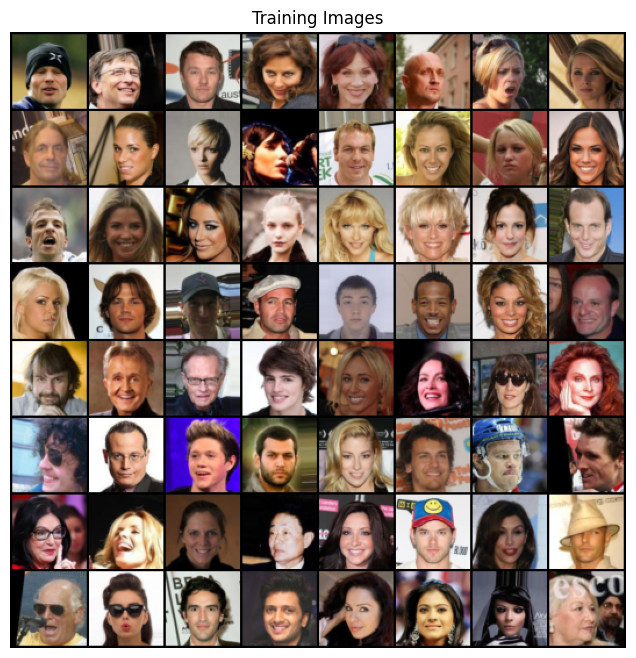

In [ ]:

# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

### (b) GAN Implementation

<h4>Weight Initialization</h4>

All model weights in GAN should be randomly initialized from a Normal distribution with `mean = 0`, `stdev = 0.02`. The ``weights_init`` function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization.




In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

<h4>Generator</h4>

The generator $G$, is designed to map the latent space vector
$z$ to data-space. Since our data are images, converting
$z$ to data-space means ultimately creating an RGB image with the
same size as the training images (i.e. 3x64x64). In practice, this is
accomplished through a series of strided two dimensional convolutional
transpose layers, each paired with a 2D batch norm layer and a relu
activation. The output of the generator is fed through a tanh function
to return it to the input data range of $[-1,1]$.




```
Generator(
  (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)
```

In [ ]:
import torch.nn as nn
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    # todo: implement network architecture
    self.conv_layers = nn.Sequential(
            nn.ConvTranspose2d(100, 512, kernel_size=4, stride=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

  def forward(self, input):
    # todo: implement network architecture
    x = self.conv_layers(input)
    return x

Now, we can instantiate the generator and apply the ``weights_init``
function.


In [ ]:
# Create the generator
netG = Generator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (conv_layers): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()

<h4>Discriminator</h4>

The discriminator $D$ is a binary classification
network that takes an image as input and outputs a scalar probability
that the input image is real (as opposed to fake). Here, $D$ takes
a 3x64x64 input image, processes it through a series of Conv2d,
BatchNorm2d, and ReLU layers, and outputs the final probability
through a Sigmoid activation function. This architecture can be extended
with more layers if necessary for the problem, but there is significance
to the use of the strided convolution, BatchNorm, and ReLUs.


```
Discriminator(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): ReLU()
  (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): ReLU()
  (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (12): Sigmoid()
)
```

In [ ]:
import torch.nn as nn
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    # TODO: implement network architecture
    self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, bias=False),
            nn.Sigmoid()
        )



  def forward(self, input):
    # TODO: implement network architecture
    x = self.conv_layers(input)
    return x

Now, as with the generator, we can create the discriminator, apply the
``weights_init`` function, and print the model’s structure.




In [ ]:
# Create the Discriminator
netD = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


<h4>Loss Functions and Optimizers</h4>

With $D$ and $G$ setup, we can specify how they learn
through the loss functions and optimizers. We will use the Binary Cross
Entropy loss
([`BCELoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss))
function which is defined in PyTorch as:

\begin{align}\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad l_n = - \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right]\end{align}

Notice how this function provides the calculation of both log components
in the objective function (i.e. $\log(D(x))$ and
$\log(1-D(G(z)))$). We can specify what part of the BCE equation to
use with the $y$ input. This is accomplished in the training loop
which is coming up soon, but it is important to understand how we can
choose which component we wish to calculate just by changing $y$
(i.e. GT labels).

Next, we define our real label as 1 and the fake label as 0. These
labels will be used when calculating the losses of $D$ and
$G$, and this is also the convention used in the original GAN
paper. Finally, we set up two separate optimizers, one for $D$ and
one for $G$. In the training loop, we will periodically input
this fixed_noise into $G$, and over the iterations we will see
images form out of the noise.




In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop

num_epochs = 10
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device) # what does cpu mean?
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/10][0/1583]	Loss_D: 1.5262	Loss_G: 5.0881	D(x): 0.6084	D(G(z)): 0.5670 / 0.0084
[0/10][50/1583]	Loss_D: 1.2590	Loss_G: 27.8726	D(x): 0.9901	D(G(z)): 0.6539 / 0.0000
[0/10][100/1583]	Loss_D: 0.0678	Loss_G: 5.4217	D(x): 0.9621	D(G(z)): 0.0117 / 0.0089
[0/10][150/1583]	Loss_D: 0.4056	Loss_G: 5.0916	D(x): 0.9703	D(G(z)): 0.2756 / 0.0084
[0/10][200/1583]	Loss_D: 0.3912	Loss_G: 3.8368	D(x): 0.7660	D(G(z)): 0.0201 / 0.0385
[0/10][250/1583]	Loss_D: 0.4049	Loss_G: 5.2786	D(x): 0.8181	D(G(z)): 0.1122 / 0.0146
[0/10][300/1583]	Loss_D: 2.3187	Loss_G: 3.0199	D(x): 0.2613	D(G(z)): 0.0039 / 0.1290
[0/10][350/1583]	Loss_D: 0.2600	Loss_G: 3.6865	D(x): 0.8636	D(G(z)): 0.0801 / 0.0419
[0/10][400/1583]	Loss_D: 0.4374	Loss_G: 5.1662	D(x): 0.9154	D(G(z)): 0.2556 / 0.0113
[0/10][450/1583]	Loss_D: 0.3845	Loss_G: 3.3334	D(x): 0.7978	D(G(z)): 0.0675 / 0.0623
[0/10][500/1583]	Loss_D: 0.5545	Loss_G: 6.3336	D(x): 0.8835	D(G(z)): 0.2815 / 0.0043
[0/10][550/1583]	Loss_D: 0.4202	Loss_G: 3

<h4>Training</h4>

Finally, now that we have all of the parts of the GAN framework defined,
we can train it. Be mindful that training GANs is somewhat of an art
form, as incorrect hyperparameter settings lead to mode collapse with
little explanation of what went wrong. Here, we will closely follow
Algorithm 1 from Goodfellow’s paper, while abiding by some of the best
practices shown in [`ganhacks`](https://github.com/soumith/ganhacks).
Namely, we will construct different mini-batches for real and fake
images, and also adjust G’s objective function to maximize
$\log (D(G(z)))$. Training is split up into two main parts. Part 1
updates the Discriminator and Part 2 updates the Generator.

**Part 1: Train the Discriminator**

Recall, the goal of training the discriminator is to maximize the
probability of correctly classifying a given input as real or fake. In
terms of Goodfellow, we wish to “update the discriminator by ascending
its stochastic gradient”. Practically, we want to maximize
$\log(D(x)) + \log(1-D(G(z)))$. Due to the separate mini-batch
suggestion from ganhacks, we will calculate this in two steps. First, we
will construct a batch of real samples from the training set, forward
pass through $D$, calculate the loss ($\log(D(x))$), then
calculate the gradients in a backward pass. Secondly, we will construct
a batch of fake samples with the current generator, forward pass this
batch through $D$, calculate the loss ($\log(1-D(G(z)))$),
and *accumulate* the gradients with a backward pass. Now, with the
gradients accumulated from both the all-real and all-fake batches, we
call a step of the Discriminator’s optimizer.

**Part 2: Train the Generator**

As stated in the original paper, we want to train the Generator by
minimizing $\log(1-D(G(z)))$ in an effort to generate better fakes.
As mentioned, this was shown by Goodfellow to not provide sufficient
gradients, especially early in the learning process. As a fix, we
instead wish to maximize $\log(D(G(z)))$. In the code we accomplish
this by: classifying the Generator output from Part 1 with the
Discriminator, computing G’s loss *using real labels as GT*, computing
G’s gradients in a backward pass, and finally updating G’s parameters
with an optimizer step. It may seem counter-intuitive to use the real
labels as GT labels for the loss function, but this allows us to use the
$\log(x)$ part of the BCELoss (rather than the $\log(1-x)$
part) which is exactly what we want.

Finally, we will do some statistic reporting and at the end of each
epoch we will push our fixed_noise batch through the generator to
visually track the progress of G’s training. The training statistics
reported are:

-  **Loss_D** - discriminator loss calculated as the sum of losses for
   the all real and all fake batches ($\log(D(x)) + \log(D(G(z)))$).
-  **Loss_G** - generator loss calculated as $\log(D(G(z)))$
-  **D(x)** - the average output (across the batch) of the discriminator
   for the all real batch. This should start close to 1 then
   theoretically converge to 0.5 when G gets better. Think about why
   this is.
-  **D(G(z))** - average discriminator outputs for the all fake batch.
   The first number is before D is updated and the second number is
   after D is updated. These numbers should start near 0 and converge to
   0.5 as G gets better. Think about why this is.

**Note:** This step might take a while, depending on how many epochs you
run and if you removed some data from the dataset.




<h4>Visualization</h4>

Finally, lets check out how we did. Here, we will look at three
different results. First, we will see how D and G’s losses changed
during training. Second, we will visualize G’s output on the fixed_noise
batch for every epoch. And third, we will look at a batch of real data
next to a batch of fake data from G.

**Loss versus training iteration**

Below is a plot of D & G’s losses versus training iterations.




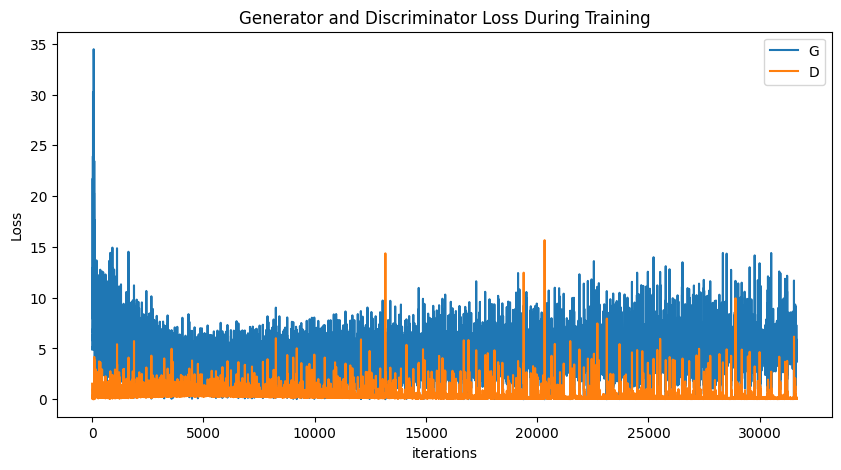

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Visualization of G’s progression**

Remember how we saved the generator’s output on the fixed_noise batch
after every epoch of training. Now, we can visualize the training
progression of G with an animation. Press the play button to start the
animation.




In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

**Real Images vs. Fake Images**

Finally, lets take a look at some real images and fake images side by
side.




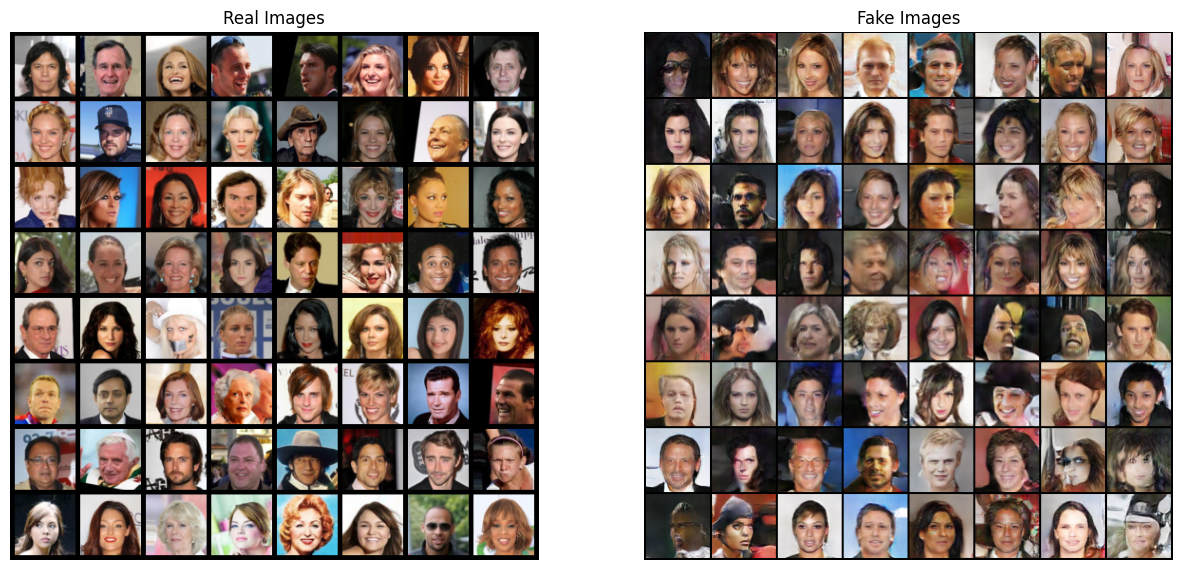

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

### Change the image size to 128x128.

Note: Do not overwrite the code for 64x64. Please copy the previous code and do the resizing below.

In [ ]:
# todo
# Root directory for dataset
dataroot = "./CelebA1"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

In [ ]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
import torch.nn as nn
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    # todo: implement network architecture
    self.conv_layers = nn.Sequential(
            nn.ConvTranspose2d(100, 512, kernel_size=4, stride=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

  def forward(self, input):
    # todo: implement network architecture
    x = self.conv_layers(input)
    return x

In [ ]:
# Create the generator
netG = Generator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

In [ ]:
import torch.nn as nn
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    # TODO: implement network architecture
    self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, bias=False),
            nn.Sigmoid()
        )



  def forward(self, input):
    # TODO: implement network architecture
    x = self.conv_layers(input)
    return x

In [ ]:
# Create the Discriminator
netD = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop

num_epochs = 10
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device) # what does cpu mean?
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

### (c) Discussions


(1) Why does the training strategy for GAN need to be carefully designed?



(2) Besides generating fake images from the noise, what other applications can you come up with for GAN?
